In [1]:
import glob, sys
import numpy as np
import matplotlib.pyplot as plt
import time
import pyccl as ccl
cosmo = ccl.Cosmology(Omega_c = 0.30711 - 0.048254, Omega_b = 0.048254, h = 0.677, sigma8 = 0.8288, n_s=0.96)

In [2]:
%load_ext autoreload
%autoreload 2
sys.path.append('/pbs/throng/lsst/users/cpayerne/GitForThesis/DC2Analysis/modeling/')
import CL_COUNT_class_cluster_abundance as cl_count

initialize the `ClusterAbundance` object

In [3]:
clc = cl_count.ClusterAbundance()
#choose the halo mass function and mass definition
massdef = ccl.halos.massdef.MassDef(200, 'critical', c_m_relation=None)
hmd = ccl.halos.hmfunc.MassFuncTinker08(cosmo, mass_def=massdef)
clc.set_cosmology(cosmo = cosmo, hmd = hmd, massdef = massdef)
clc.sky_area = (0.25)*4*np.pi

# Binned approach
Compute the 2D integral

$$
N_{\alpha\beta}^{\rm predicted} = \Omega_s\int_{z_\alpha}^{z_{\alpha + 1}} dz\int_{\log_{10}M_\beta}^{\log_{10}M_{\beta + 1}}\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}d\log_{10}M
$$

define mass & redshift binning

In [4]:
z_corner = np.linspace(0.25, 1.25, 16)
logm_corner = np.linspace(14, 14.8, 11)
def binning(corner): return [[corner[i],corner[i+1]] for i in range(len(corner)-1)]
Z_bin = binning(z_corner)
logMass_bin = binning(logm_corner)

Three different methods:
1. Simpson integration of a tabulated grid of $\Omega\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}$ (method `simps`)
2. Double integral using `scipy.integrate.dblquad` over a interpolated function based on a tabulated grid of $\Omega\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}$ (method `dblquad_interp`)
3. Double integral using `scipy.integrate.dblquad` of $\Omega\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}$ (method `exact_CCL`

In [5]:
#define redshift-mass grid
z_grid = np.linspace(0., 3, 300)
logm_grid = np.linspace(12,16, 300)

`simps`

In [6]:
t0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance_simps = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'simps')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
time_simps = t1-t0

time (seconds) = 0.26944541931152344


`dblquad_interp`

In [7]:
t0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
Abundance_dblquad_interp = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'dblquad_interp')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
time_dblquad_interp = t1-t0

time (seconds) = 4.941214084625244


`exact_CCL`

In [8]:
t0 = time.time()
Abundance_dbquad = clc.Cluster_Abundance_MZ(Redshift_bin = Z_bin, Proxy_bin = logMass_bin, method = 'exact_CCL')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))
time_exact_CCL = t1-t0

time (seconds) = 63.45270109176636


We plot the biais of the 2 first methods relative to the `exact_CCL` method

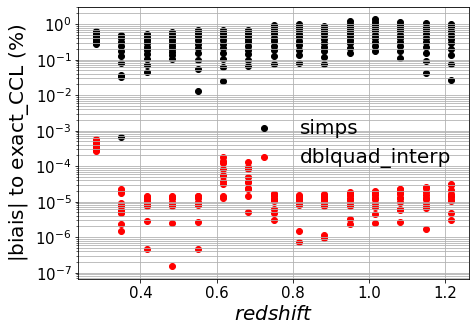

In [9]:
plt.figure(figsize = (7,5))
plt.yscale('log')
z_ = np.mean(Z_bin, axis = 1)
mass = np.mean(logMass_bin, axis = 1)
plt.tick_params(axis='both', which="both", labelsize= 15)
for f in range(len(logMass_bin)):
    label = [None, None]
    if f == 0:
        label = ['simps', 'dblquad_interp']
    y_simps = abs(100*(1-Abundance_simps[:,f]/Abundance_dbquad[:,f]))
    y_dbquad_interp = abs(100*(1-Abundance_dblquad_interp[:,f]/Abundance_dbquad[:,f]))
    plt.scatter(z_, y_simps, color = 'k', label = label[0])
    plt.scatter(z_, y_dbquad_interp, color = 'r', label = label[1])
plt.grid(True, which="both" )
plt.ylabel(r'|biais| to exact_CCL $(\%)$', fontsize = 20)
plt.xlabel(r'$redshift$', fontsize = 20)
plt.legend(frameon = False, fontsize = 20)
plt.show()

# Un-binned approach

Compute $$\frac{d^2V(z_i)}{dz d\Omega}\frac{dn(M_i,z_i)}{d\log_{10}M_i}$$ for each masses and redshifts in a dark matter halo catalog

In [10]:
#Generate mass, redshift catalog
n_cluster = 100000
redshift, M200c = np.random.random(n_cluster)*(1 - 0.2) + 0.2, 10**(np.random.random(n_cluster)*(15 - 13) + 13)

Method :
1. compute individual $\frac{d^2V(z)}{dz d\Omega}\frac{dn(M,z)}{d\log_{10}M}$ from an interpolated function over a tabulated grid
2. use CCL prediction for each dark matter halo mass ad redshift

In [11]:
t0 = time.time()
clc.compute_multiplicity_grid_MZ(z_grid = z_grid, logm_grid = logm_grid)
multiplicity_interp = clc.multiplicity_function_individual_MZ(z = redshift, logm = np.log10(M200c), method = 'interp')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))

time (seconds) = 0.1808915138244629


In [12]:
t0 = time.time()
multiplicity_CCL = clc.multiplicity_function_individual_MZ(z = redshift, logm = np.log10(M200c), method = 'exact_CCL')
t1 = time.time()
print('time (seconds) = ' + str(t1-t0))

time (seconds) = 23.510751962661743


Text(0, 0.5, '|biais| to CCL $(\\%)$')

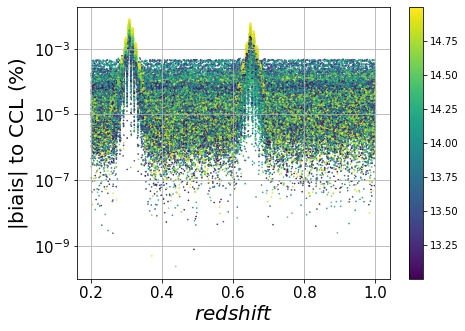

In [13]:
plt.figure(figsize = (7,5))
plt.yscale('log')
plt.tick_params(axis='both', which = 'major', labelsize= 15)
plt.scatter(redshift, abs(100*(1-multiplicity_interp/np.array(multiplicity_CCL))), s = 0.4, c = np.log10(M200c))
plt.colorbar()
plt.grid(True, which='both')
plt.xlabel(r'$redshift$', fontsize = 20)
plt.ylabel(r'|biais| to CCL $(\%)$', fontsize = 20)